#### Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report

In [25]:
# константы
# ядро для генератора случайных чисел
my_seed = 22
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
mpl.style.use('bmh')
sns.set_palette("flare_r")

##### Данные своего варианта из упражнения 3 (на регуляризацию и снижение размерности) разделить на выборку для построения моделей (85%) и отложенные наблюдения (15%). Отложенные наблюдения использовать только для прогноза по лучшей модели.

In [3]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)
# функция, которая строит график важности признаков в модели случайного леса
# источник: https://www.analyseup.com/learn-python-for-data-science/python-rand
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
    inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

In [4]:
df_raw = pd.read_csv('./winequality-red_for_lab.csv')
df_all = df_raw[['citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'Y']]
df = df_all.sample(frac = 0.85, random_state = my_seed)
df_predict = df_all.drop(df.index)
df.head(5)

,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,pH,sulphates,alcohol,Y
959,0.05,2.0,0.089,12.0,0.99735,3.36,0.61,10.0,0
1447,0.00,1.9,0.080,22.0,0.99701,3.40,0.74,9.7,0
1481,0.60,3.0,0.104,10.0,0.99828,3.39,0.68,10.6,0
1106,0.42,1.9,0.069,9.0,0.99376,3.21,0.54,12.3,1
924,0.27,2.3,0.055,14.0,0.99516,3.18,0.80,11.2,0


##### Построить модель дерева с обрезкой ветвей и оптимизировать её параметр с помощью перекрёстной проверки. Указать, чему равно оптимальное значение параметра. Представить дерево графически, если его размер позволяет.

In [5]:
# выращиваем дерево на всех объясняющих
X = df.drop(['Y'], axis=1)
y = df['Y']
# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy', random_state=my_seed)
tree_full = cls_one_tree.fit(X, y)
# выводим количество листьев (количество узлов)
tree_full.get_n_leaves()

226

In [6]:
tree_full.get_depth()

16

Дерево оказалось достаточно большим.

In [7]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5, scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')
print('Acc с перекрёстной проверкой', '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.715


Подберём оптимальное количество ветвей, которое максимизирует Acc.

In [8]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 129
Энтропия листьев для первых 5 значений alpha: [0.         0.00202714 0.00441501 0.00588668 0.00735835]


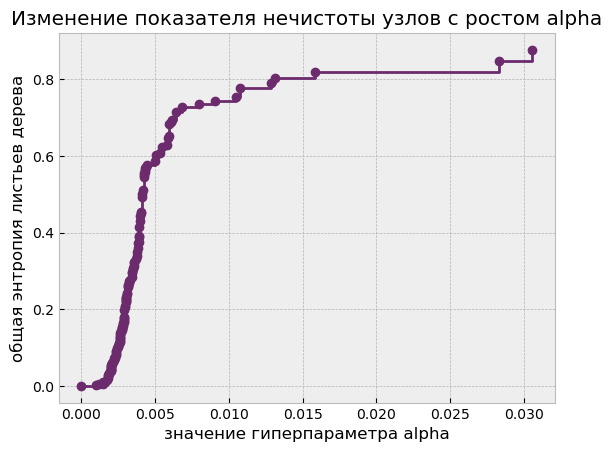

In [26]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [10]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_seed)
# модели
clfs = list()
# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 0.72 секунд


In [11]:
# извлекаем характеристики глубины и точности
# таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
# таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 0.38 секунд


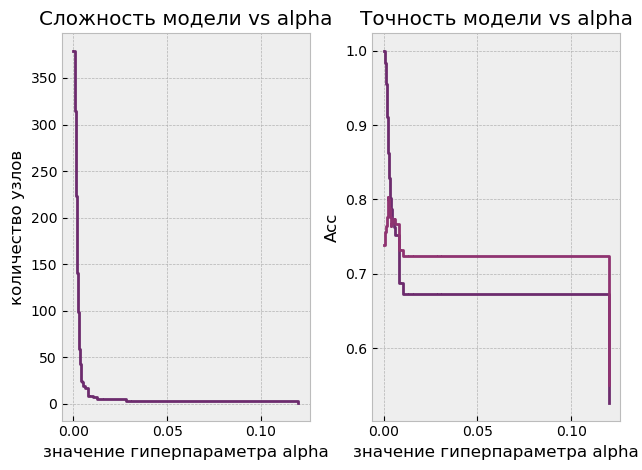

In [27]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)
# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")
# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train', drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test', drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели vs alpha")
fig.tight_layout()

In [13]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5, scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')
print('Оптимальное количество узлов:', opt_nodes_num, 
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой для модели c обрезкой ветвей :', np.around(np.mean(cv), 3))

Оптимальное количество узлов: 101 
соответствующая Acc на тестовой: 0.803 

Acc с перекрёстной проверкой для модели c обрезкой ветвей : 0.728


In [14]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

17

In [15]:
# глубина дерева: количество узлов от корня до листа в самой длинной ветви
clfs[opt_nodes_num].get_depth()

8

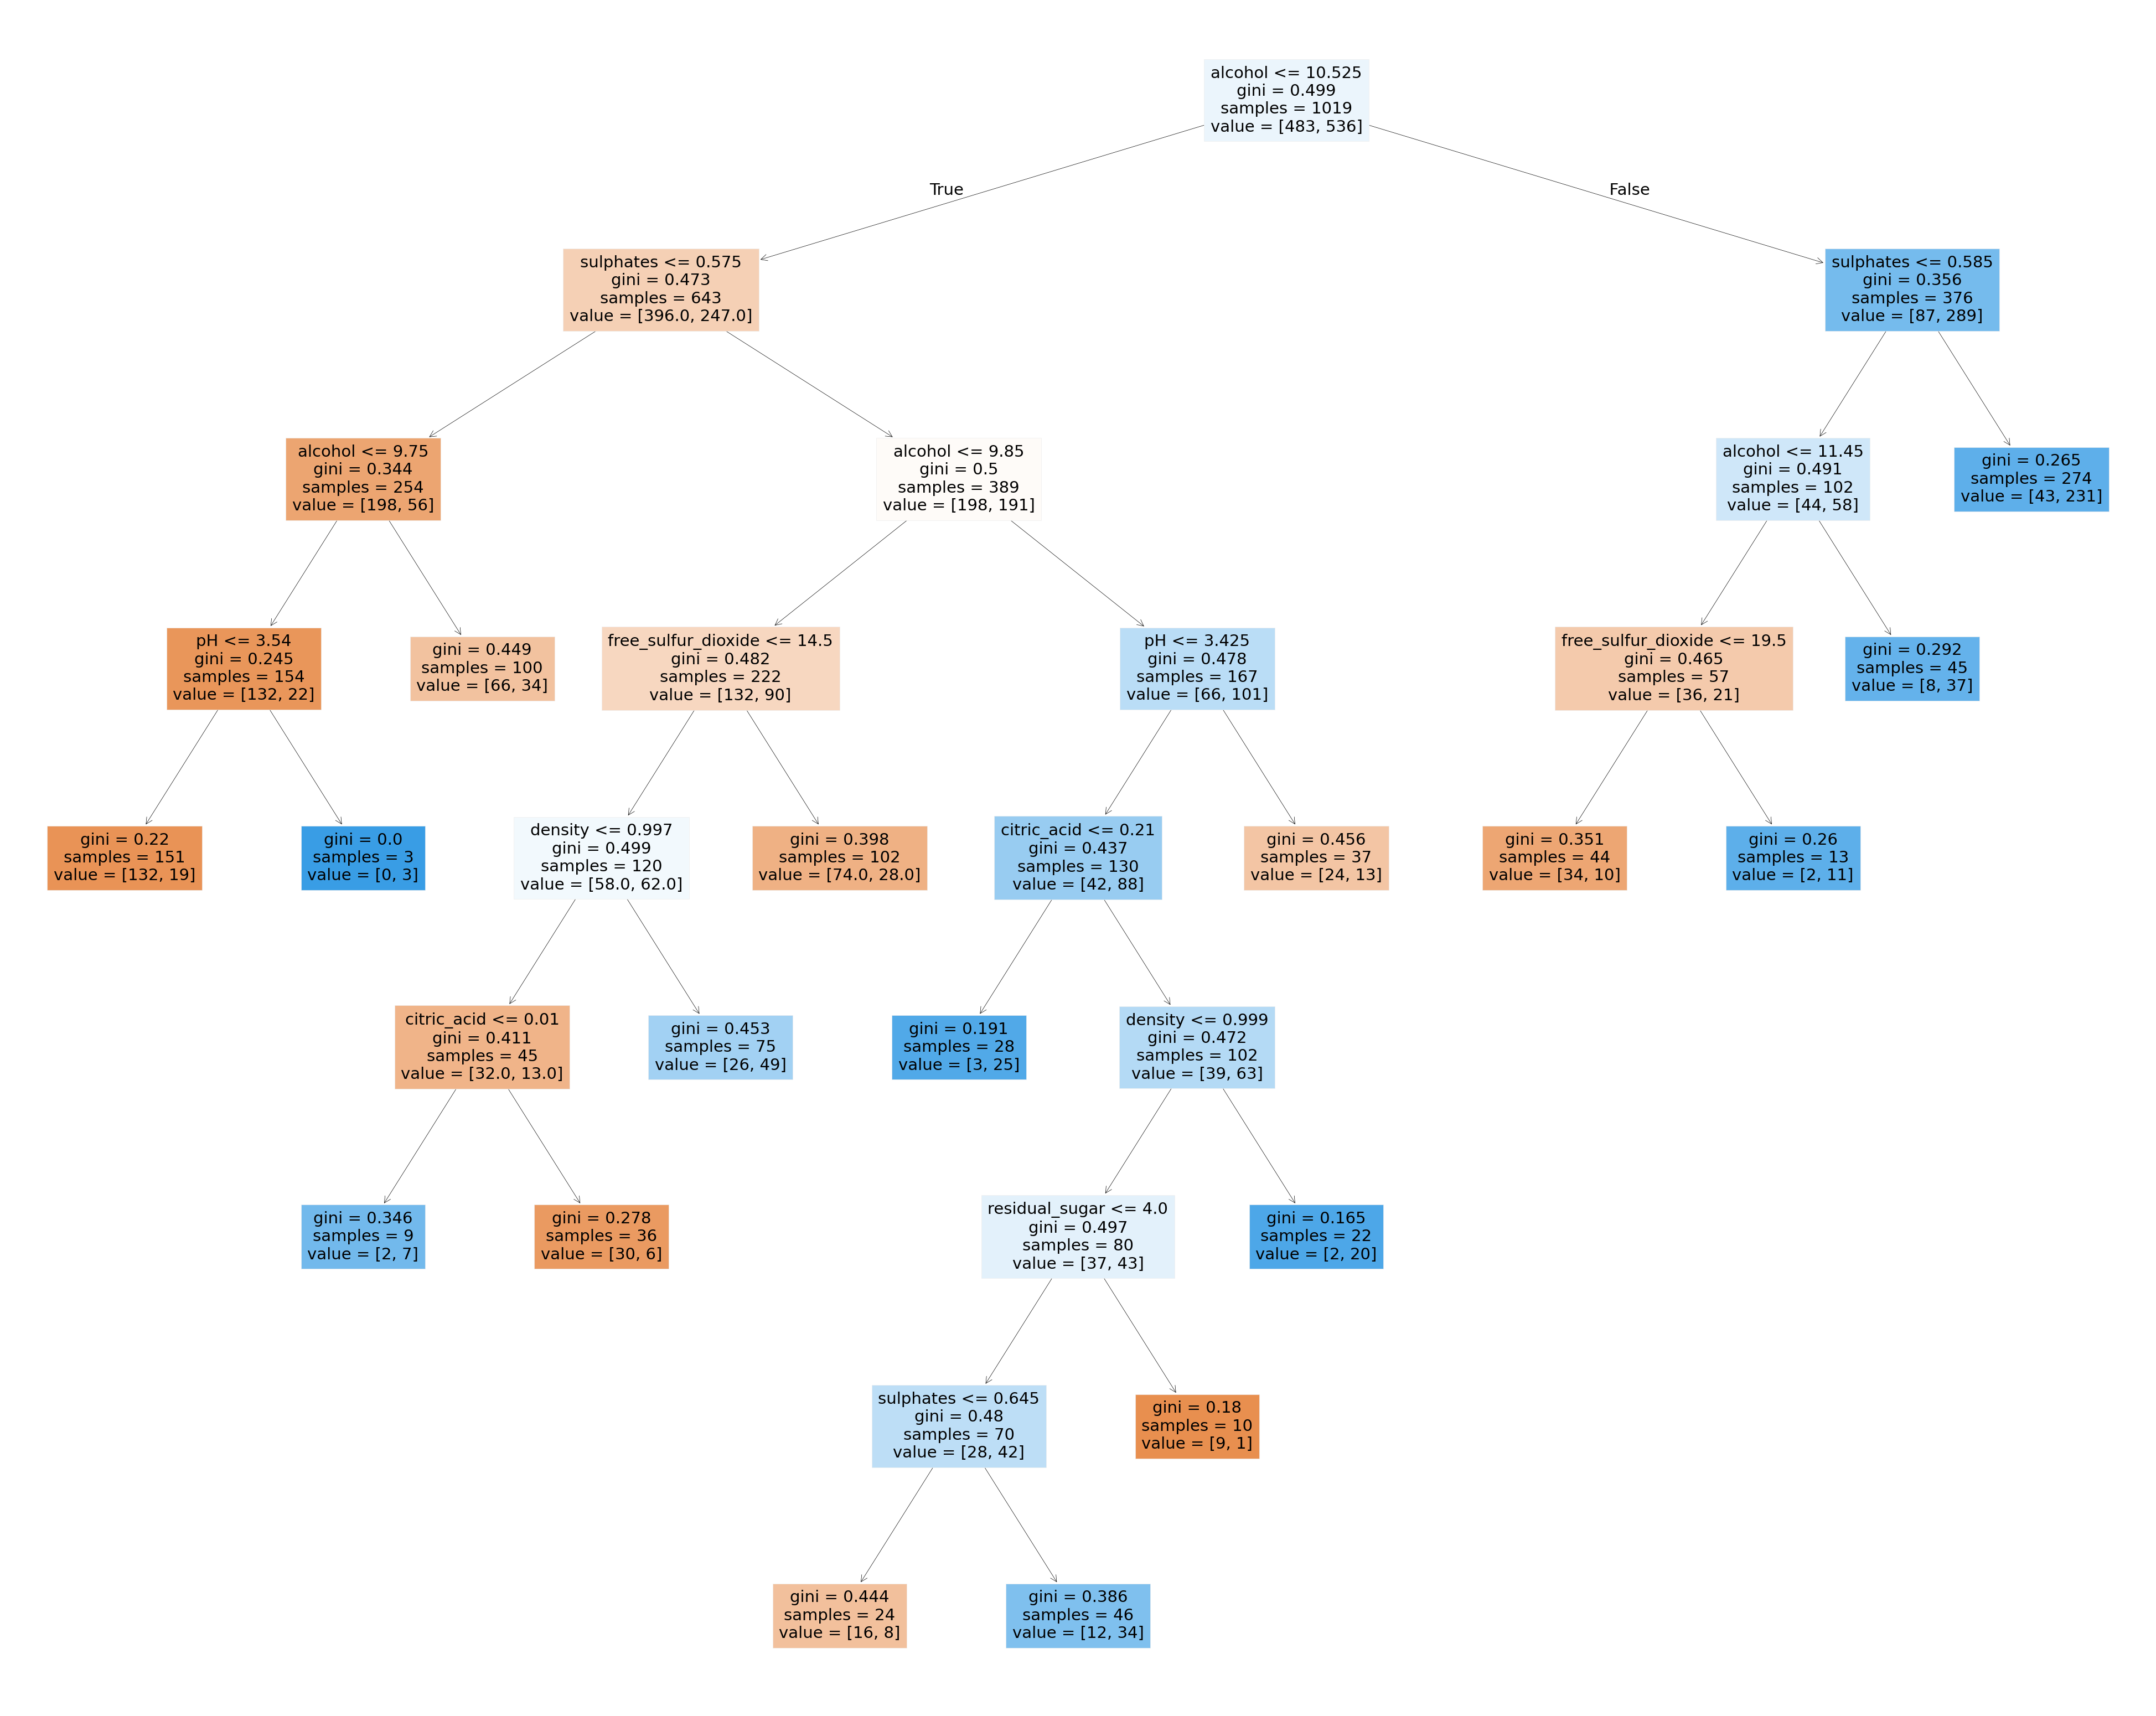

In [28]:
fig = plt.figure(figsize=(50, 40))
_ = plot_tree(clfs[opt_nodes_num], filled=True, feature_names=X.columns)

##### Построить модель методом случайного леса, оптимизировав её параметры с помощью перекрёстной проверки. Для сеточного поиска взять не менее 7 различных значений для каждого настроечного параметра. Указать оптимальные значения параметров.

In [17]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для параметра количества признаков для построения отдельного дерева m: p, p/2, sqrt(p) и log2(p)
#ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms = np.unique([
    1,
    int(np.sqrt(X_m)),
    int(X_m / 2),
    int(2 * X_m / 3),
    X_m, 
    *np.linspace(1, X_m, num=7, dtype=int)
])
ms

array([1, 2, 3, 4, 5, 6, 8])

In [18]:
# параметр B: количество деревьев
num_trees = 50
# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [8, 16, 24, 32, 40, 48, 56], 'max_features' : ms}
# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 25.69 секунд


In [19]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.792

In [20]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

48

In [21]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

1

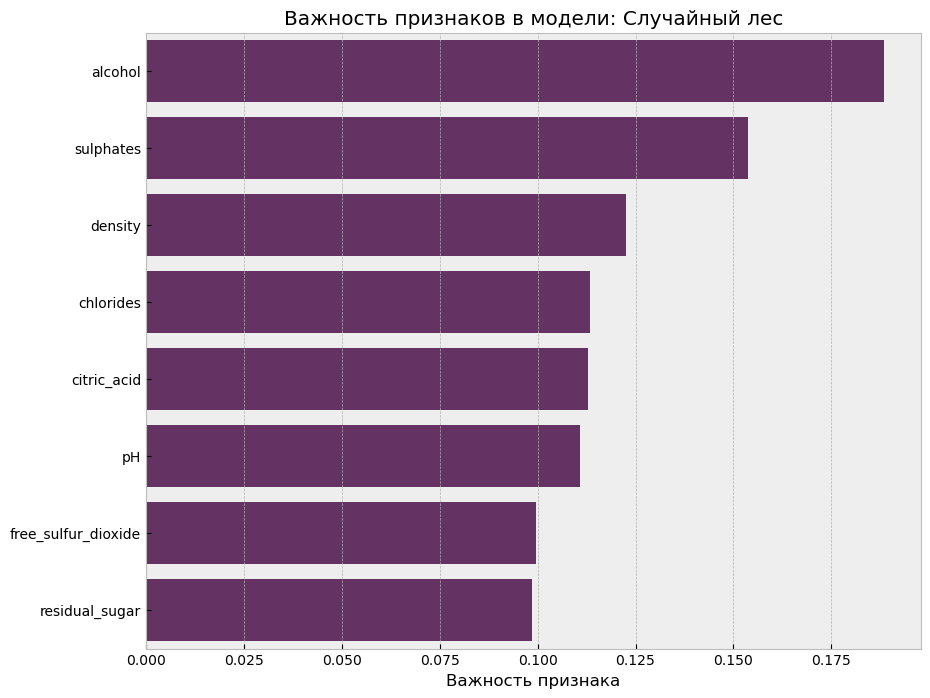

In [29]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Случайный лес')

In [23]:
# записываем точность
print('Acc с перекрёстной проверкой для модели «случайный лес»', np.around(random_forest.best_score_, 3))

Acc с перекрёстной проверкой для модели «случайный лес» 0.792


#### Выбрать наиболее точную модель из полученных в пунктах 2 и 3.

Acc для модели с обрезкой ветвей составила 0,728, а для модели случайного леса — 0,794. Как видим, модель случайного леса точнее.

#### Сделать по ней прогноз на отложенные наблюдения, оценить точность этого прогноза.

In [24]:
# данные для прогноза
X_pred = df_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(df_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       108
           1       0.82      0.82      0.82       132

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240



Видим общую высокую точность 0,8.

#### Сравнить точность на отложенных наблюдениях с точностью моделей из упражнения 3.

В упражнении 3 были построены модель логистической регрессии и ее регуляризация методом лассо-регрессии. Точность лучшей из этих моделей (лассо-регрессия) на отложенных наблюдениях составила 0,74. Модель случайного леса с точностью 0,8 для наших данных оказалась лучше в предсказании.